In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Style Transfer
<p style='font-size:15px'>In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

<p style='font-size:15px'>The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

<p style='font-size:15px'>The deep network we use as a feature extractor is VGG-16 that has been trained on ImageNet. You could use any network, but we chose VGG-16 here.

# Setup

In [2]:
import vgg
import tensorflow as tf
slim = tf.contrib.slim
import os
from scipy.misc import imread, imresize
import numpy as np
import matplotlib.pyplot as plt
from image_utils import load_image, preprocess_image, deprocess_image,VGG_MEAN

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Pre-trained Model
<p style='font-size:15px'>Load the pretrained VGG-16 model, see `vgg.py` for the model architecture. 

<p style='font-size:15px'>To use VGG-16, you will need to first **download the weights** by downloading `vgg_16_2016_08_28.tar.gz`. Once you unzip it, you will have the `vgg_16.ckpt` that includes all the learned parameters.

<p style='font-size:15px'>Once you've downloaded the model and weights, you can run the following cell to load the model in TensorFlow. Please understand the code before you continue.

In [3]:
tf.reset_default_graph()
#define input image placeholder
X = tf.placeholder(dtype=tf.float32,shape=[None,None,None,3])

#initialize vgg-16 model
#scores: the output of last layer
#end_points: include all layers outputs
scores, end_points = vgg.vgg_16(inputs=X,num_classes=1000,is_training=False,dropout_keep_prob=1.)

#get the variables to restore
variables_to_restore = slim.get_variables_to_restore()
#define saver
saver = tf.train.Saver(variables_to_restore)
#create the session
sess = get_session()
#restore the variables
saver.restore(sess,"vgg_16.ckpt")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg_16.ckpt


# Part a: Computing Loss

<p style='font-size:15px'>We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

## a.1: Content loss
<p style='font-size:15px'>We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

<p style='font-size:15px'>Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times H_\ell \times W_\ell \times C_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

<p style='font-size:15px'>Then the content loss is given by:

<p style='font-size:15px'>$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [4]:
def content_loss(content_weight, content_current, content_target):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: scalar constant we multiply the content_loss by.
    - content_current: features of the current image, Tensor with shape [1, height, width, channels]
    - content_target: features of the content image, Tensor with shape [1, height, width, channels]
    
    Returns:
    - scalar content loss
    """
    #extract the images
    #array = your_tensor.eval(session=your_session)
    curr = content_current[0]
    targ = content_target[0]
    
    #do pixel by pixel loss comparison
    sub = content_current - content_target
    mul = tf.multiply(sub, sub)
    loss = tf.reduce_sum(mul) * content_weight
    
    return loss

## a.2: Style loss
<p style='font-size:15px'>Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

<p style='font-size:15px'>First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

<p style='font-size:15px'>Given a feature map $F^\ell$ of shape $(M_\ell, C_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

<p style='font-size:15px'>$$G_{ij}^\ell  = \sum_k F^{\ell}_{ki} F^{\ell}_{kj}$$

<p style='font-size:15px'>Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

<p style='font-size:15px'>$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

<p style='font-size:15px'>In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

<p style='font-size:15px'>$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

<p style='font-size:15px'>Begin by implementing the Gram matrix computation below:

In [5]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: Tensor of shape (1, H, W, C) giving features for
      a single image.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: Tensor of shape (C, C) giving the (optionally normalized)
      Gram matrices for the input image.
    """
    #extract the images
    feat = features[0]
    
    #get the shape
    h = tf.shape(features)[1]
    w = tf.shape(features)[2]
    c = tf.shape(features)[3]
    
    #reshape the features
    features_1 = tf.reshape(features, [h*w, c])
    
    #calculate the gram
    gram = tf.matmul(tf.transpose(features_1), features_1)
    multiply_vals = tf.cast(h*w*c, tf.float32)
    
    #normalize
    if normalize:
        val = 1/multiply_vals
        return tf.scalar_mul(val,gram)
    else:
        return gram

Next, implement the style loss:

In [6]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: dictionary of the features at every layer of the current image
    - style_layers: List of layer names into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A Tensor containing the scalar style loss.
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    
    full_loss = 0
    for i in range(len(style_layers)):
        #get the gram
        curr_layer = feats.get(style_layers[i])
        curr_gram = gram_matrix(curr_layer)
        
        #apply loss function
        sub = curr_gram - style_targets[i]
        mul = tf.multiply(sub, sub)
        loss = tf.reduce_sum(mul)
        
        #summ with full loss
        full_loss += style_weights[i] * loss
        
    
    return full_loss

## a.3 :Total-variation regularization
<p style='font-size:15px'>It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

<p style='font-size:15px'>You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

<p style='font-size:15px'>$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

<p style='font-size:15px'>In the next cell, fill in the definition for the TV loss term. To receive full credit, your implementation should not have any loops.

In [7]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (1, H, W, 3) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
     #extract the images and make some shifted copies
    img_ = img[0]
    img_h = img_[1:]
    img_w = img_[:, 1:]
    
    
    #get the dimensions
    h, w, c = img_.shape
    
    #apply shifted images
    sub_h = img_h - img_[0:h-1]
    mul_h = tf.multiply(sub_h, sub_h)
    loss_h = tf.reduce_sum(mul_h)
    
    sub_w = img_w - img_[:, 0:w-1]
    mul_w = tf.multiply(sub_w, sub_w)
    loss_w = tf.reduce_sum(mul_w)
    
    
    return tv_weight * (loss_w + loss_h)

# Part b: Style Transfer

<p style='font-size:15px'>Lets put it all together and make some beautiful images! The `style_transfer` function below combines all the losses you coded up above and optimizes for an image that minimizes the total loss.

In [8]:
def style_transfer(content_image, style_image,image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    #Extract features from the content image
    content_img = preprocess_image(load_image(content_image,size=image_size))
    content_target = sess.run(end_points[content_layer],feed_dict={X:content_img[None]})
    
    #Extract features from the style image
    style_img = preprocess_image(load_image(style_image,size=style_size))
    style_feat_vars = [end_points[idx] for idx in style_layers]
    style_target_vars = []
    
    #Compute list of TensorFlow Gram Matrices
    for style_feat_var in style_feat_vars:
        style_target_vars.append(gram_matrix(style_feat_var))
    
    #Compute list of Numpy Gram matrices by evaluating the TensorFlow graph on the style image
    style_targets = sess.run(style_target_vars,feed_dict = {X:style_img[None]})
    
    #Initialize generated image to content image
    if init_random:
        img_var = tf.Variable(tf.random_uniform(content_img[None].shape, 0.0, 255.0), name="image")
    else:
        img_var = tf.Variable(content_img[None],name="image")
    
    #Extract features on generated image
    _,end_points_ = vgg.vgg_16(inputs=img_var,num_classes=1000,is_training=False,dropout_keep_prob=1.,reuse=tf.AUTO_REUSE)
    #Compute loss
    c_loss = content_loss(content_weight,end_points_[content_layer],content_target)
    s_loss = style_loss(end_points_,style_layers,style_targets,style_weights)
    t_loss = tv_loss(img_var,tv_weight)
    
    loss = c_loss + s_loss + t_loss
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    max_iter = 200

    # Create and initialize the Adam optimizer
    lr_var = tf.Variable(initial_lr, name="lr")
    # Create train_op that updates the generated image when run
    with tf.variable_scope("optimizer") as opt_scope:
        train_op = tf.train.AdamOptimizer(lr_var).minimize(loss, var_list=[img_var])
    # Initialize the generated image and optimization variables
    opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=opt_scope.name)
    sess.run(tf.variables_initializer([lr_var, img_var] + opt_vars))
    # Create an op that will clamp the image values when run
    clamp_image_op = tf.assign(img_var, tf.clip_by_value(img_var, -VGG_MEAN, VGG_MEAN))
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # Hardcoded handcrafted 
    for t in range(max_iter):
        # Take an optimization step to update img_var
        sess.run(train_op)
        #print(sess.run(loss))
        if t < decay_lr_at:
            sess.run(clamp_image_op)
        if t == decay_lr_at:
            sess.run(tf.assign(lr_var, decayed_lr))
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            img = sess.run(img_var)
            plt.imshow(deprocess_image(img[0]))
            plt.axis('off')
            plt.show()
    print('Iteration {}'.format(t))
    img = sess.run(img_var)        
    plt.imshow(deprocess_image(img[0]))
    plt.axis('off')
    plt.show()

## Generate some pretty pictures!

Try out `style_transfer` on the three different parameter sets below. Below the next three cells of code (in which you are free to change the hyperparameters), feel free to copy and paste the parameters to play around them and see how the resulting image changes. Choose the most beautiful results you believe as final results.

In addition to the provided three sets, you will choose two images on your own and create an interesting creative picture.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

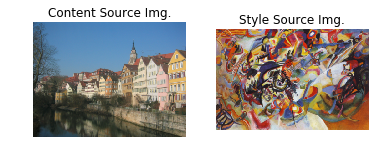

Iteration 0


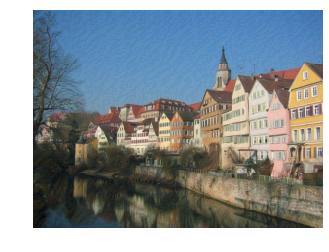

Iteration 100


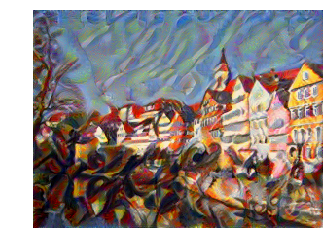

Iteration 199


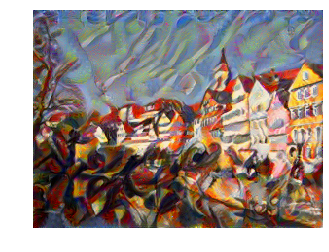

In [9]:
#Composition VII + Tubingen (feel free to change the hyper-parameters)
params1 = {'content_image': 'styles/tubingen.jpg',
            'style_image' : 'styles/composition_vii.jpg',
            'image_size':224, 
            'style_size':224,
            'content_layer' : 'vgg_16/conv2/conv2_1',
            'content_weight' :5e-2, 
            'style_layers' : ['vgg_16/conv1/conv1_1',
                 'vgg_16/conv2/conv2_1', 
                      'vgg_16/conv3/conv3_2', 
                'vgg_16/conv4/conv4_1'],
            'style_weights' : (20000,500,120,100),
            'tv_weight': 5e-2}

style_transfer(**params1)

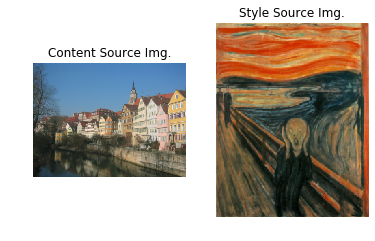

Iteration 0


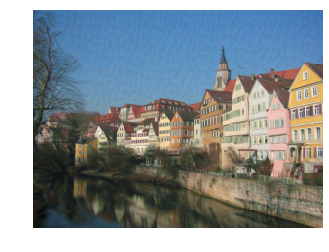

Iteration 100


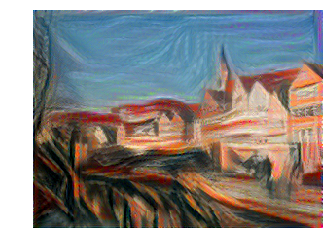

Iteration 199


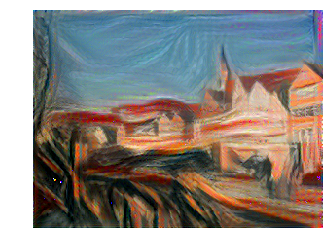

In [10]:
# Scream + Tubingen (feel free to change the hyper-parameters)
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
     'image_size':224, 
     'style_size':224,
    'content_layer':'vgg_16/conv3/conv3_1',
    'content_weight':1,
    'style_layers' : ['vgg_16/conv1/conv1_1',
                'vgg_16/conv2/conv2_1',
                     'vgg_16/conv3/conv3_1', 
                'vgg_16/conv4/conv4_1'], 
    'style_weights':[2000, 800, 12000, 1000],
    'tv_weight':10,
}

style_transfer(**params2)

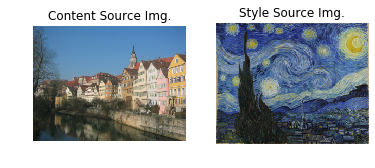

Iteration 0


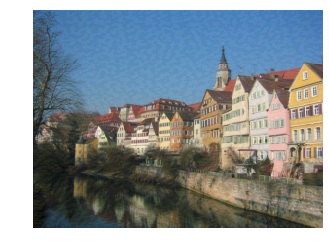

Iteration 100


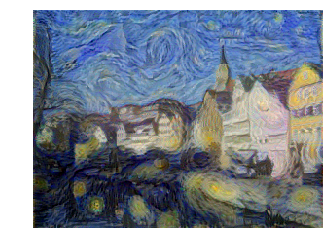

Iteration 199


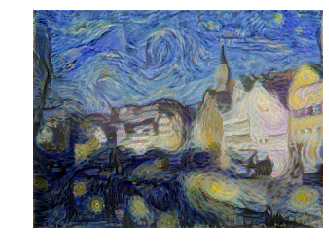

In [11]:
# Starry Night + Tubingen (feel free to change the hyper-parameters)
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 224,
    'style_size' : 224,
    'content_layer':'vgg_16/conv3/conv3_1',
    'content_weight':5e-2,
    'style_layers' : ['vgg_16/conv1/conv1_1', 'vgg_16/conv1/conv1_2',
                'vgg_16/conv2/conv2_2', 'vgg_16/conv2/conv2_2', 
                     'vgg_16/conv3/conv3_3', 'vgg_16/conv3/conv3_2', 'vgg_16/conv3/conv3_3', 
                'vgg_16/conv4/conv4_1','vgg_16/conv4/conv4_2', 'vgg_16/conv4/conv4_3', 
                'vgg_16/conv5/conv5_1', 'vgg_16/conv5/conv5_2', 'vgg_16/conv5/conv5_3'],
    'style_weights' : [10000,10000,5000,5000,10000,10000,10000,10000,10000,10000,5000,10000,10000],
    'tv_weight' : 10
}

style_transfer(**params3)

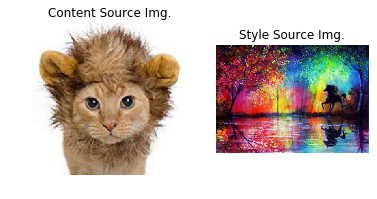

Iteration 0


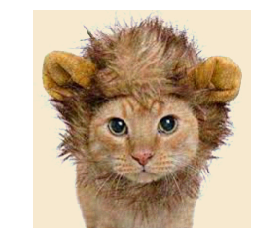

Iteration 100


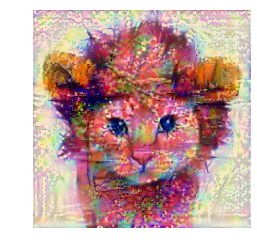

Iteration 199


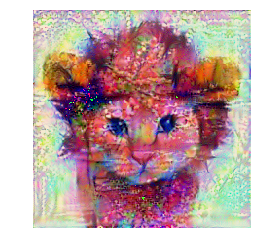

In [18]:
#Your own pictures
params4 = {
    'content_image' : 'styles/lion.jpg',
    'style_image' : 'styles/rainbow.jpg',
    'image_size' : 224,
    'style_size' : 224,
    'content_layer':'vgg_16/conv3/conv3_1',
    'content_weight':5e-2,
    'style_layers' : ['vgg_16/conv1/conv1_1', 'vgg_16/conv1/conv1_2',
                'vgg_16/conv2/conv2_2', 'vgg_16/conv2/conv2_2', 
                     'vgg_16/conv3/conv3_3', 'vgg_16/conv3/conv3_2', 'vgg_16/conv3/conv3_3', 
                'vgg_16/conv4/conv4_1','vgg_16/conv4/conv4_2', 'vgg_16/conv4/conv4_3', 
                'vgg_16/conv5/conv5_1', 'vgg_16/conv5/conv5_2', 'vgg_16/conv5/conv5_3'],
    'style_weights' : [10000,10000,5000,5000,10000,10000,10000,10000,10000,10000,5000,10000,10000],
    'tv_weight' : 30
}

style_transfer(**params4)

## Feature Inversion

The code you've written can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper [1] attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015


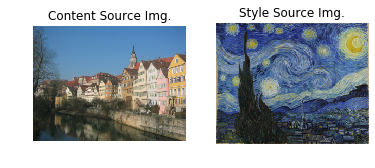

Iteration 0


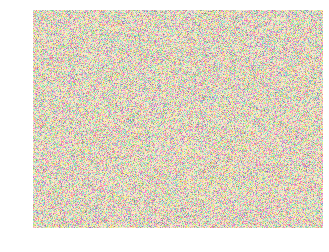

Iteration 100


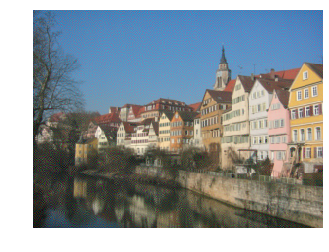

Iteration 199


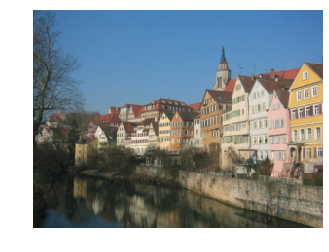

In [13]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 224,
    'style_size' : 224,
    'content_layer' : 'vgg_16/conv1/conv1_1',
    'content_weight' : 5e-2,
    'style_layers' : ['vgg_16/conv1/conv1_1',
                'vgg_16/conv2/conv2_1',
                     'vgg_16/conv3/conv3_1', 
                'vgg_16/conv4/conv4_1'],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)